In [2]:
# Heading 1
## Subheading 1.1
### Subheading 1.1.1
## Subheading 1.2
# Heading 2


# Project 3


#
**Problem Statement**
- Is it clear what the goal of the project is?
- What type of model will be developed?
- How will success be evaluated?
- Is the scope of the project appropriate?
- Is it clear who cares about this or why this is important to investigate?
- Does the student consider the audience and the primary and secondary stakeholders?

## Problem Statment: 

## 1. Using PRAW, you'll collect posts from two subreddits of your choosing.

In [3]:
#python -m pip install praw
import praw
import pandas as pd
import nltk
import pandas as np
import unicodedata
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split 
from textblob import Word
import numpy as np
import spacy
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
reddit = praw.Reddit(
    client_id='zus9cDU7x8IncmqOLReFYA',
    client_secret='3O1U8qnB3GGxPE4UtM3tpTq1qMuXfA',
    user_agent='Pro3',
    username='-__A__-',
    password=''
)

In [5]:
# Below is JUST an example of how you can use PRAW

# Choose your subreddit
subreddit_DataScience = reddit.subreddit('DataScience')
subreddit_wallstreetbets = reddit.subreddit('wallstreetbets')

# Adjust the limit as needed -- Note that this will grab the 25 most recent posts
posts_DS = subreddit_DataScience.new(limit=1525)
posts_wsb = subreddit_wallstreetbets.new(limit=1525)

In [6]:
data = []
for post in posts_DS:
    data.append([post.created_utc, post.title, post.selftext, post.subreddit])

# Turn into a dataframe
boardgames = pd.DataFrame(data, columns = ['created_utc', 'title', 'self_text', 'subreddit'])
boardgames.head()

,created_utc,title,self_text,subreddit
0,1.697744e+09,Which city in the USA has the most Asian male ...,,datascience
1,1.697744e+09,Careers in DS and mechanics,"I am about to graduate with a Bachelors in DS,...",datascience
2,1.697741e+09,Predictive vs Explanatory modeling,In my past work I've become familiar with vari...,datascience
3,1.697741e+09,What tech job to get before becoming Data Anal...,I’ve been studying Data Science for quite some...,datascience
4,1.697736e+09,Wrong data in dataset,I have a very broad question about building a ...,datascience


In [7]:
data_wsb = []
for post in posts_wsb:
    data_wsb.append([post.created_utc, post.title, post.selftext, post.subreddit])

# Turn into a dataframe
boardgames_wsb = pd.DataFrame(data_wsb, columns = ['created_utc', 'title', 'self_text', 'subreddit'])
boardgames_wsb.head()

,created_utc,title,self_text,subreddit
0,1.697745e+09,His 335c didn't hit,,wallstreetbets
1,1.697745e+09,Oof 🙃,,wallstreetbets
2,1.697744e+09,$SPY showing the same signs as $NVDA -BEARISH ...,We’re at a crucial moment in the market. \n\nI...,wallstreetbets
3,1.697744e+09,Bitcoin YOLO time?,,wallstreetbets
4,1.697744e+09,"Anybody else's options chain ""break"" at 9am?",So i was trading 0dtes on spy today and at 9am...,wallstreetbets


In [8]:
df = pd.concat([boardgames, boardgames_wsb])


In [9]:
df.subreddit.value_counts()

datascience       855
wallstreetbets    734
Name: subreddit, dtype: int64

In [10]:
df.head()

,created_utc,title,self_text,subreddit
0,1.697744e+09,Which city in the USA has the most Asian male ...,,datascience
1,1.697744e+09,Careers in DS and mechanics,"I am about to graduate with a Bachelors in DS,...",datascience
2,1.697741e+09,Predictive vs Explanatory modeling,In my past work I've become familiar with vari...,datascience
3,1.697741e+09,What tech job to get before becoming Data Anal...,I’ve been studying Data Science for quite some...,datascience
4,1.697736e+09,Wrong data in dataset,I have a very broad question about building a ...,datascience


### 

In [11]:
#df['subreddit'] = df['subreddit'].map({'wallstreetbets': 0 , 'datascience': 1})

### Shuffling the DataFrame 

In [12]:
df = df.sample(frac = 1)
df[:10]

,created_utc,title,self_text,subreddit
681,1.696443e+09,Can’t wait,,wallstreetbets
207,1.697054e+09,Any value to an unrelated advanced degree to g...,I'm a PhD in biology and my next step in the p...,datascience
520,1.695576e+09,Looking for any critiques/improvement for gett...,,datascience
579,1.696603e+09,Who dis?,,wallstreetbets
322,1.697140e+09,War Plays,"Where one person sees panic, others see profit...",wallstreetbets
202,1.697449e+09,Chinese local governments rush to issue bonds ...,,wallstreetbets
824,1.694866e+09,"Data science is not for me, is it?",I have 2.5 years of experience as a data scien...,datascience
213,1.697005e+09,Creating a Visualizations Map,Hi Everyone\n\nI am a new data analyst in an i...,datascience
3,1.697744e+09,Bitcoin YOLO time?,,wallstreetbets
605,1.696562e+09,I went negative in roth Ira???,I bought an put option and went negative $500?...,wallstreetbets


### Fearture engineering and pre-processing

Merging title and self_text

In [13]:
df['post'] = df.apply(lambda row: f"title: {row['title']} text: {row['self_text']}", axis=1)
df.head()

,created_utc,title,self_text,subreddit,post
681,1.696443e+09,Can’t wait,,wallstreetbets,title: Can’t wait text:
207,1.697054e+09,Any value to an unrelated advanced degree to g...,I'm a PhD in biology and my next step in the p...,datascience,title: Any value to an unrelated advanced degr...
520,1.695576e+09,Looking for any critiques/improvement for gett...,,datascience,title: Looking for any critiques/improvement f...
579,1.696603e+09,Who dis?,,wallstreetbets,title: Who dis? text:
322,1.697140e+09,War Plays,"Where one person sees panic, others see profit...",wallstreetbets,title: War Plays text: Where one person sees p...


In [14]:
df.drop(['title','self_text', 'created_utc'], axis=1, inplace=True)

In [15]:
df.head()

,subreddit,post
681,wallstreetbets,title: Can’t wait text:
207,datascience,title: Any value to an unrelated advanced degr...
520,datascience,title: Looking for any critiques/improvement f...
579,wallstreetbets,title: Who dis? text:
322,wallstreetbets,title: War Plays text: Where one person sees p...


### Preprocessing
I making use of Regex to remove numbers and links from the post and creating a new column called cleaned post with processed text.

In [16]:
pattern = r'\b\d+\b|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
df['cleaned_post'] = df['post'].replace(pattern, '', regex=True)

# EDA
* Starting off with highest single word count.
* Highest bigrams count
* Highest trigram count

In [17]:
#intialize Coutvector
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer

#intitialize CountVectorizer 
vectorizer = CountVectorizer()

In [18]:
#fit 
wm = vectorizer.fit_transform(df['cleaned_post'])

In [19]:
wm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [20]:
df_vect_ex = pd.DataFrame(wm.toarray(), columns= vectorizer.get_feature_names_out(), index=df.index)

In [21]:
df_vect_ex

,06pm,0dte,0dtes,0s,0t,0th,1000s,100_000_000,100b,100bps,...,zepto,zero,zhang,zhuzh,zig,zillow,zone,zones,zoom,zoomer
681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_vect_ex['target_subreddit'] = df['subreddit']

In [23]:
Count_w = df_vect_ex.drop('target_subreddit', axis=1).sum().sort_values(ascending = False)

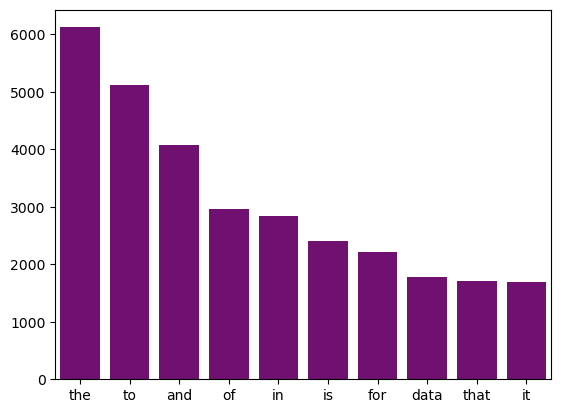

In [24]:
import seaborn as sns
sns.barplot(x=Count_w.index[:10], y = Count_w[:10], color='purple')
plt.show()

stop_words{‘english’}, list, default=None
If ‘english’, a built-in stop word list for English is used. There are several known issues with ‘english’ and you should consider an alternative (see Using stop words).

If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens. Only applies if analyzer == 'word'.
If None, no stop words will be used. In this case, setting max_df to a higher value, such as in the range (0.7, 1.0), can automatically detect and filter stop words based on intra corpus document frequency of terms.

In [25]:
def gettopten(df):
    nv = CountVectorizer(stop_words='english', token_pattern= (r'\b(?!http\b|https\b|www\b|ftp\b)(?<!http)(?<!https)(?<!www)(?<!ftp)'
           r'\b[^\d\W]+\b(?!.[a-zA-Z0-9]+\b)'))
    nvv = nv.fit_transform(df['cleaned_post'])
    df_no = pd.DataFrame(nvv.toarray(), columns= nv.get_feature_names_out(), index= df.index)
    new_count = df_no.sum().sort_values(ascending=False)
    return sns.barplot(x=new_count.index[:10],y=new_count[:10], palette='colorblind') 


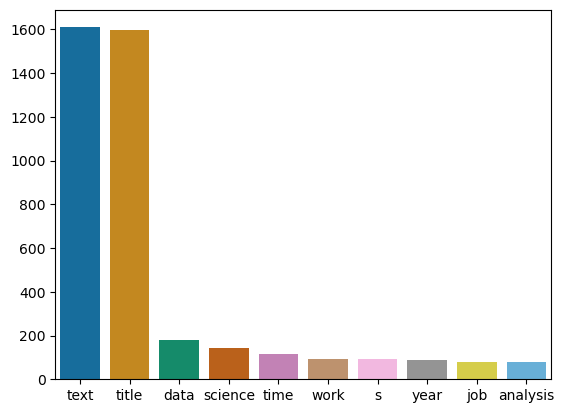

In [26]:
gettopten(df)
plt.show()

## Now we will check top 10 word counts in each subreddit

In [27]:
df[df['subreddit'] == 'datascience']

,subreddit,post,cleaned_post
207,datascience,title: Any value to an unrelated advanced degr...,title: Any value to an unrelated advanced degr...
520,datascience,title: Looking for any critiques/improvement f...,title: Looking for any critiques/improvement f...
824,datascience,"title: Data science is not for me, is it? text...","title: Data science is not for me, is it? text..."
213,datascience,title: Creating a Visualizations Map text: Hi ...,title: Creating a Visualizations Map text: Hi ...
129,datascience,title: Looking for data science job in US for ...,title: Looking for data science job in US for ...
...,...,...,...
86,datascience,title: How to use PPO policy network to find g...,title: How to use PPO policy network to find g...
413,datascience,title: How to properly sample data size down? ...,title: How to properly sample data size down? ...
528,datascience,"title: Please suggest, what should I do next? ...","title: Please suggest, what should I do next? ..."
411,datascience,title: Say I trained an autoencoder. Why is th...,title: Say I trained an autoencoder. Why is th...


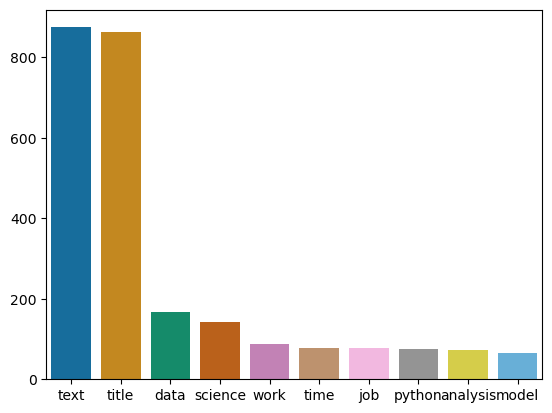

In [28]:
gettopten(df[df['subreddit'] == 'datascience'])
plt.show()

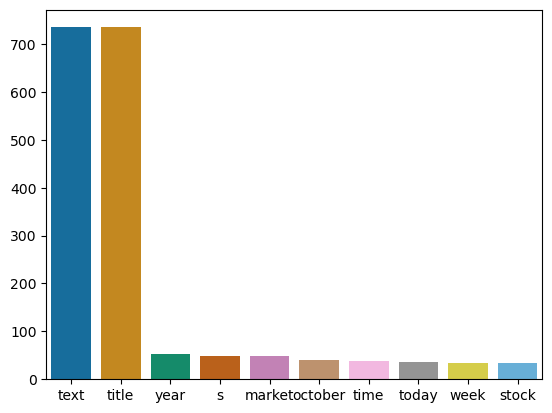

In [29]:
gettopten(df[df['subreddit'] == 'wallstreetbets'])
plt.show()

### We will use countvectorizer with ngram_range:
* ngram_range = (1,1) -> To do EDA on unigrams
* ngram_range = (2,2) -> To do EDA on bigrams
* ngram_range = (3,3) -> To do EDA on bigrams

In [30]:
def gettop10(df,n,stop='english'):
    cvec = CountVectorizer(ngram_range=(n,n), stop_words= stop)

    nvv = cvec.fit_transform(df['cleaned_post'])
    df_no = pd.DataFrame(nvv.toarray(), columns= cvec.get_feature_names_out(), index= df.index)
    new_count = df_no.sum().sort_values(ascending=False)
    plt.figure(figsize=(12,6))
    plt.tight_layout()
    return sns.barplot(x=new_count[:10],y=new_count.index[:10], palette='colorblind') 

## Top 10 highest occuring bigrams in the entire dataset

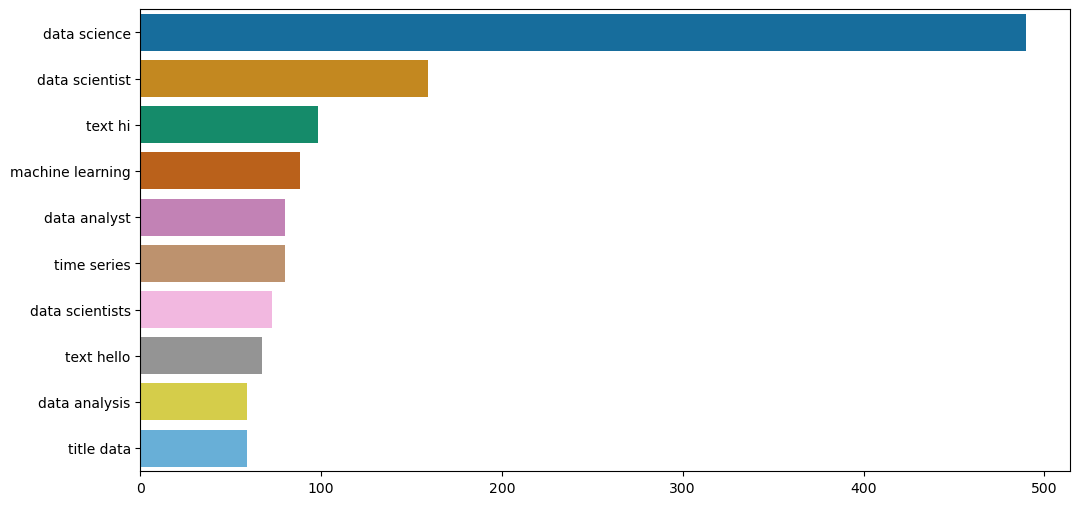

In [31]:
gettop10(df,2)
plt.show()

## Discovery:
There seems to be a word that appears frequently called `x200b`. Upon further investigation, this is the unicode for **whitespace character**. We will need to modify our post and remove this chracter with help of regex.

In [32]:
df['cleaned_post'] = df['cleaned_post'].replace(r'x200B|text|title|\n|\'', '', regex=True)

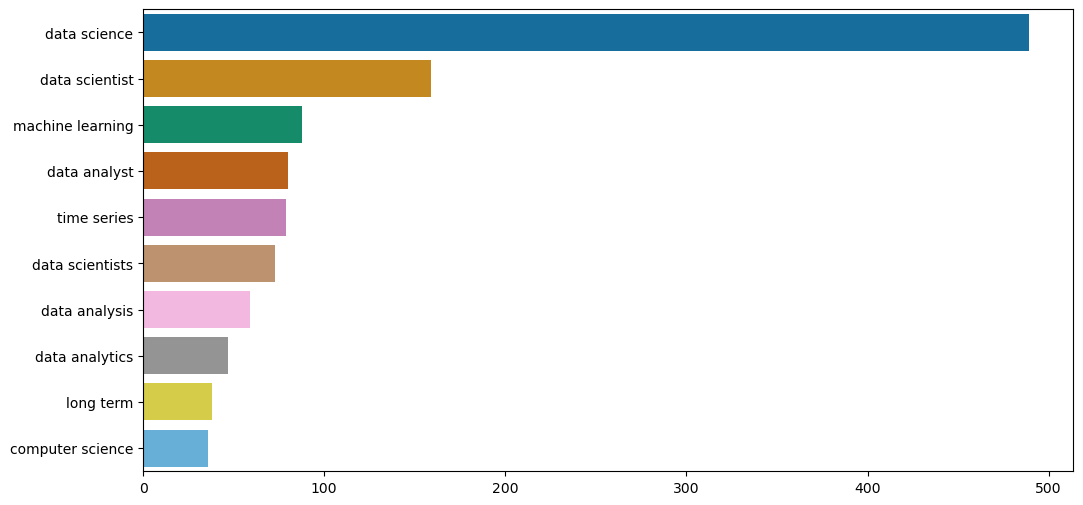

In [33]:
gettop10(df,2)
plt.show()

## Top 10 occurring bigrams in the wallstreetbets

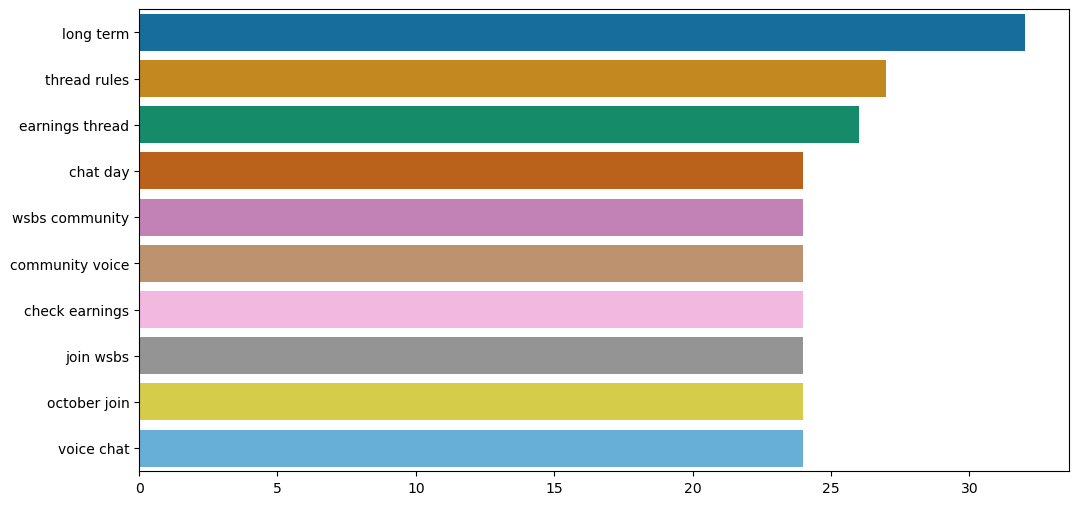

In [34]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],2)
plt.show()

## Top 10 occurring bigrams in the datascience 

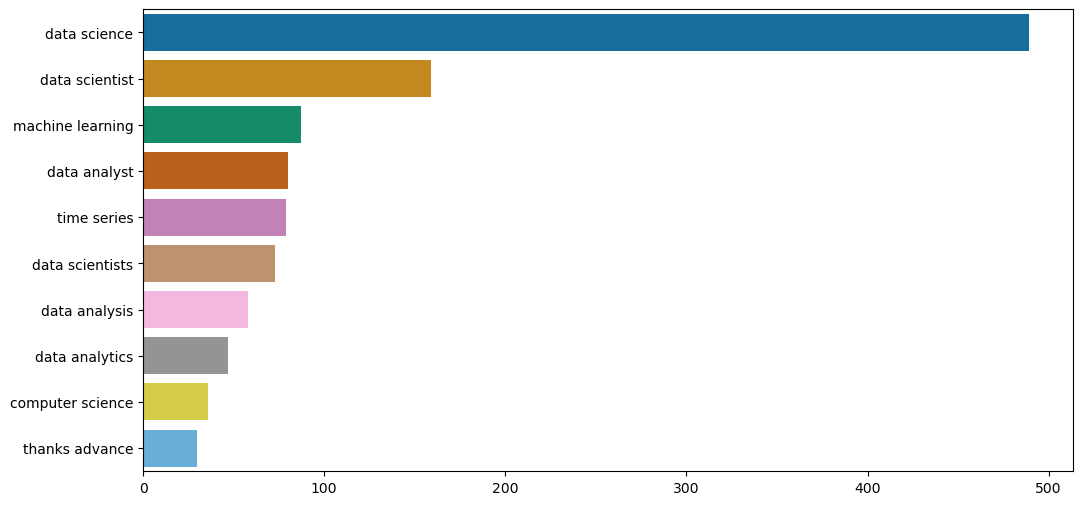

In [35]:
gettop10(df[df['subreddit'] == 'datascience'],2)
plt.show()

## Top 10 occurring trigrams in the wallstreetbets

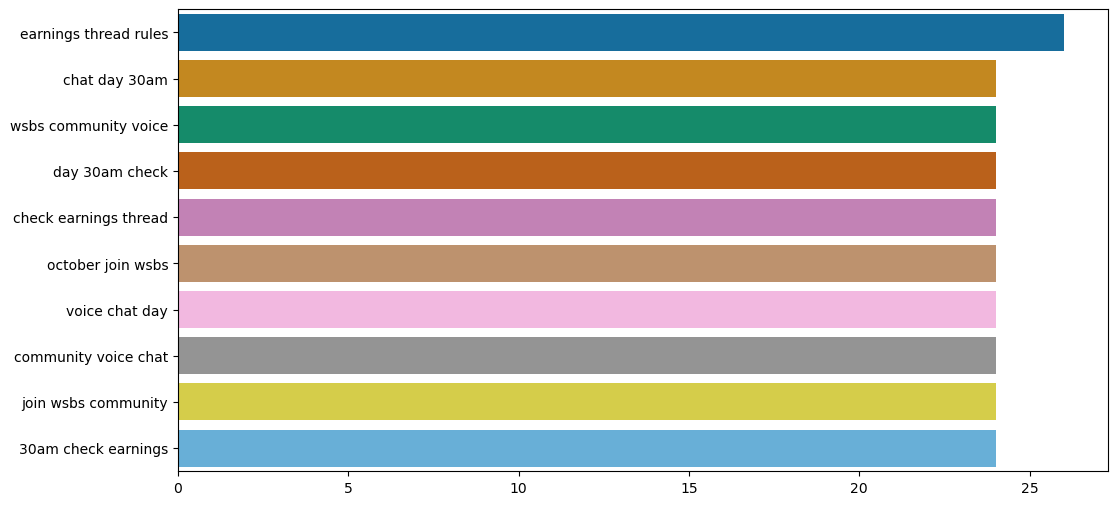

In [36]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3)
plt.show()

## Top 10 occurring trigrams in the datascience

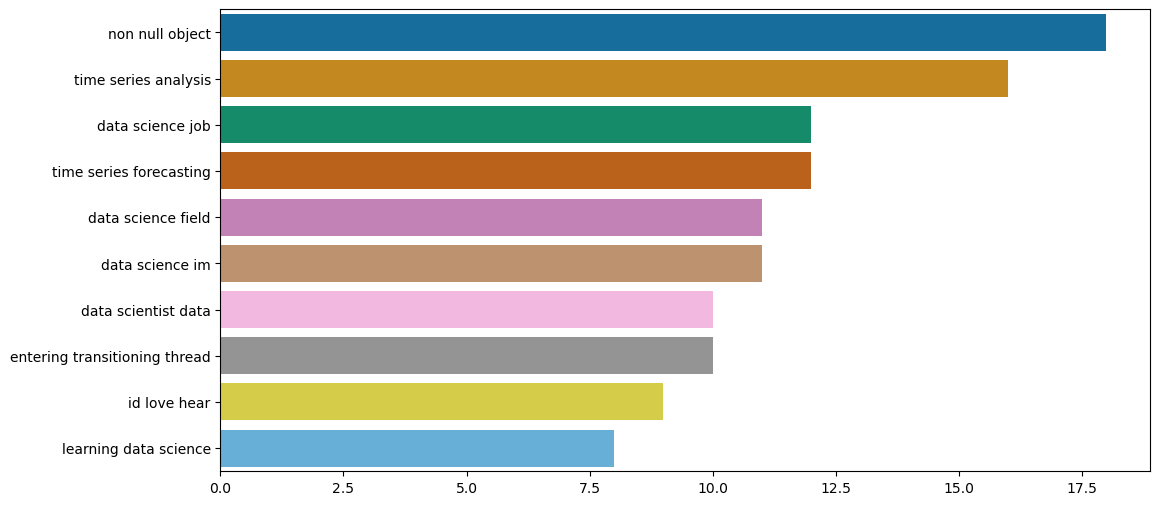

In [37]:
gettop10(df[df['subreddit'] == 'datascience'],3)
plt.show()

## Trigrams with stopwords

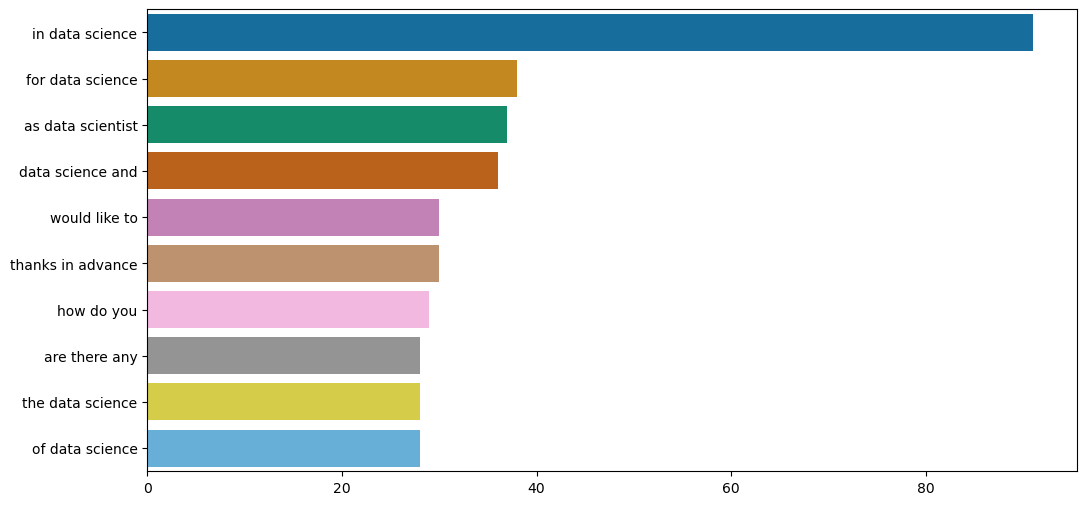

In [38]:
gettop10(df[df['subreddit'] == 'datascience'],3,stop=None)
plt.show()

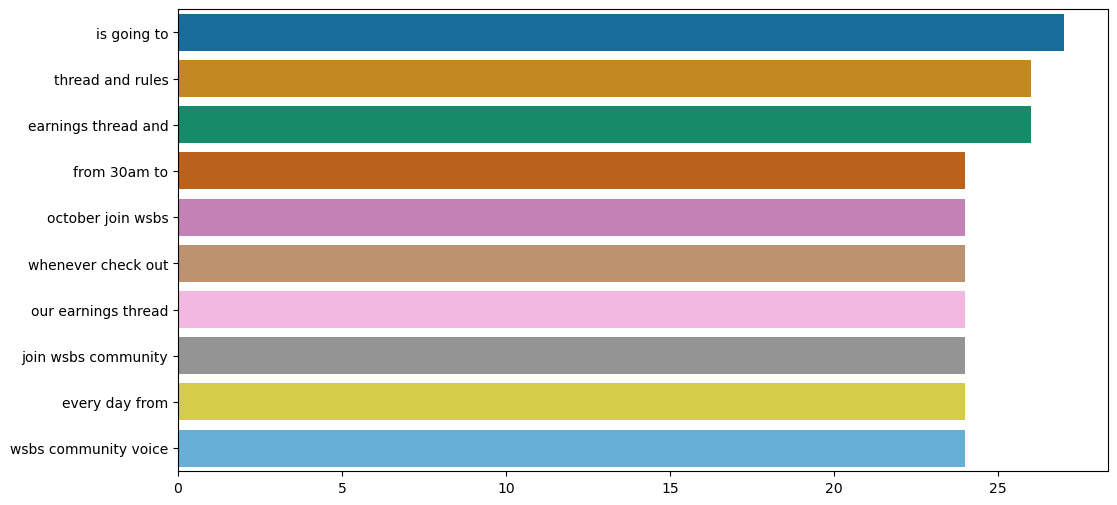

In [39]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3,stop=None)
plt.show()

## 4-gram with stopwords

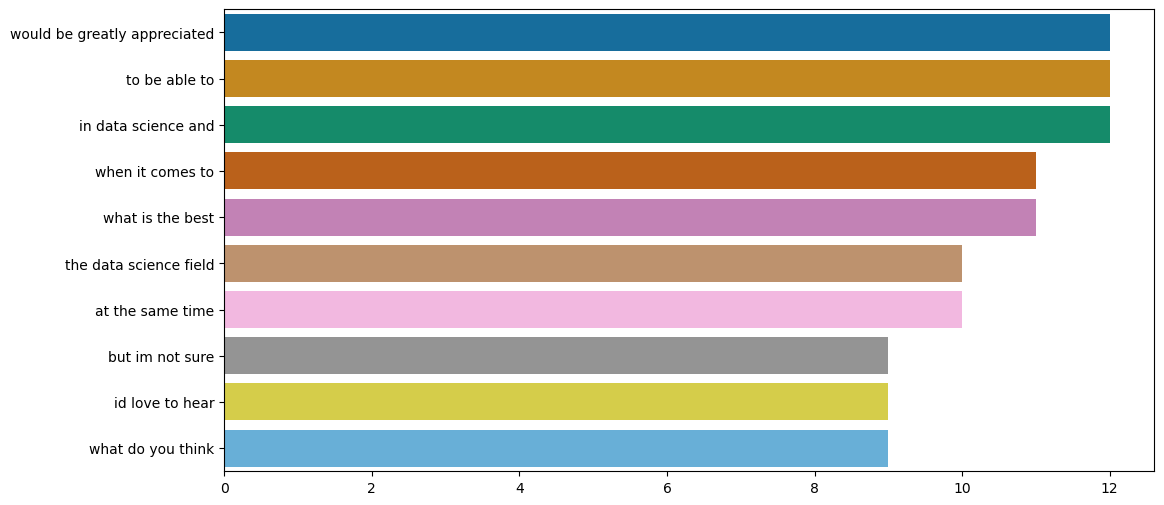

In [40]:
gettop10(df[df['subreddit'] == 'datascience'],4,stop=None)
plt.show()

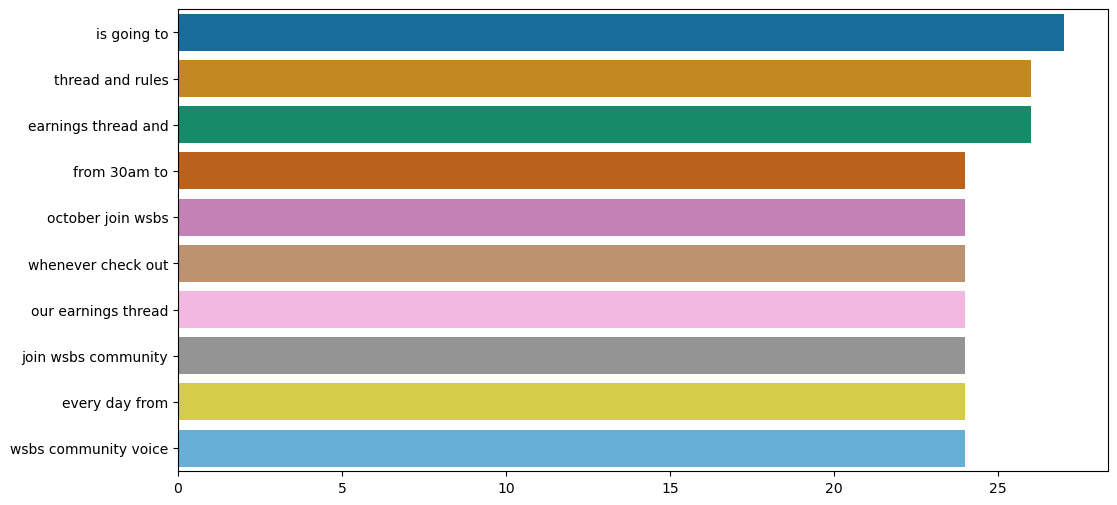

In [41]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3,stop=None)
plt.show()

## T-SNE Visulization

In [42]:
def tsne(df,n, stop='english'):
    cvec = CountVectorizer(ngram_range=(n,n), stop_words= stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    df_vectorized_matrix = pd.DataFrame(vectorized_matrix.toarray(), columns= cvec.get_feature_names_out(), index= df.index)
    df_vectorized_matrix['Sne_lables']=df['subreddits']
    return  

In [43]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.feature_extraction.text import CountVectorizer
# import pandas as pd

# def tsne_viz(df, n, stop='english'):
#     # 1. Vectorize the text data
#     cvec = CountVectorizer(ngram_range=(n,n), stop_words=stop)
#     vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
#     # 2. Compute t-SNE coordinates
#     tsne = TSNE(n_components=, random_state=42)
#     tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
#     # 3. Plot the t-SNE coordinates
#     plt.figure(figsize=(12,8))
#     sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=df['subreddit'], palette="deep", edgecolor="w", s=60)
#     plt.title('t-SNE Visualization')
#     plt.xlabel('t-SNE Dimension 1')
#     plt.ylabel('t-SNE Dimension 2')
#     plt.show()

# # Sample usage
# # tsne_viz(your_dataframe, 1)


In [44]:
#tsne_viz(df, 3, stop='english')

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def tsne_viz_3d(df, n, stop='english'):
    # 1. Vectorize the text data
    cvec = CountVectorizer(ngram_range=(n,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
    # 2. Compute t-SNE coordinates for 3D
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
    # 3. Plot the t-SNE coordinates in 3D
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], 
                         c=pd.factorize(df['subreddit'])[0], cmap="viridis", s=60)
    
    legend1 = ax.legend(*scatter.legend_elements(), title="Subreddits")
    ax.add_artist(legend1)
    
    ax.set_title('3D t-SNE Visualization')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    
    plt.show()

# Sample usage
# tsne_viz_3d(your_dataframe, 1)


c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


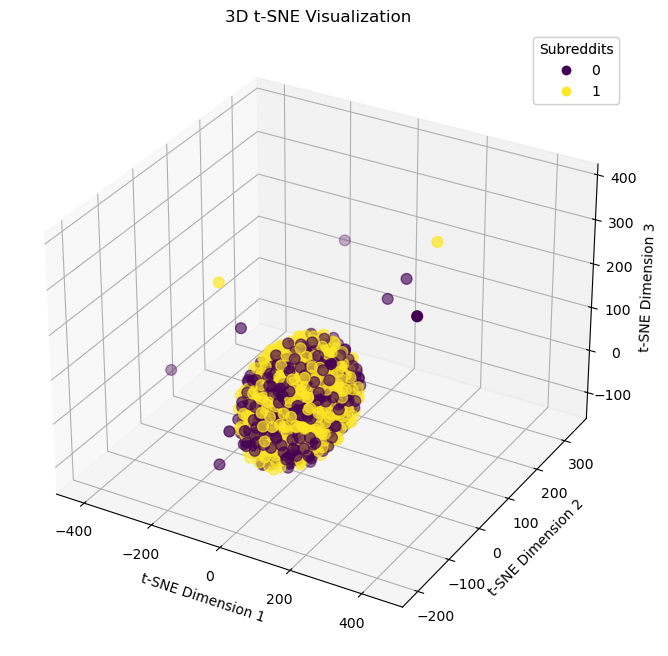

In [46]:
tsne_viz_3d(df, 3, stop='english')

In [47]:
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def tsne_viz_3d_interactive(df, n, stop='english'):
    # 1. Vectorize the text data
    cvec = TfidfVectorizer(ngram_range=(n-1,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
    # 2. Compute t-SNE coordinates for 3D
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
    # Create a DataFrame for plotting
    df_tsne = pd.DataFrame(tsne_results, columns=['dim1', 'dim2', 'dim3'])
    df_tsne['subreddit'] = df['subreddit'].reset_index(drop=True)
    
    # 3. Plot using plotly
    fig = px.scatter_3d(df_tsne, x='dim1', y='dim2', z='dim3', color='subreddit')
    fig.show()

# Sample usage
# tsne_viz_3d_interactive(your_dataframe, 1)


In [48]:
tsne_viz_3d_interactive(df, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [49]:
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def tsne_viz_3d_interactive_with_index(df, n, stop='english'):
    # 1. Vectorize the text data
    cvec = TfidfVectorizer(ngram_range=(n-1,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
    # 2. Compute t-SNE coordinates for 3D
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
    # Create a DataFrame for plotting
    df_tsne = pd.DataFrame(tsne_results, columns=['dim1', 'dim2', 'dim3'])
    df_tsne['subreddit'] = df['subreddit'].reset_index(drop=True)
    df_tsne['index'] = df.index  # Add the index as a column
    
    # 3. Plot using plotly with hover data
    fig = px.scatter_3d(df_tsne, x='dim1', y='dim2', z='dim3', color='subreddit', hover_data=['index'])
    fig.show()

# Sample usage
# tsne_viz_3d_interactive_with_index(your_dataframe, 1)


In [50]:
tsne_viz_3d_interactive_with_index(df, 2, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [51]:
tsne_viz_3d_interactive_with_index(df, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [52]:
df.iloc[35]['cleaned_post']

': Education vs Reality : For those of you in the Data Science and Analytics field, what did you learn/hear during your education that was completely irrelevant once you started working professionally?'

In [53]:
df.iloc[291]['cleaned_post']

': What should I focus on ? : Hey! So, Im trying to break into a data analysis career by learning data analysis by myself. However, I feel overwhelmed by all the content that I "have" to learn. I read some articles about the subject and some say that I should focus on general knowledge about business and data because I can learn the technical skills through the tasks that Ill be asked to accomplish. Others say that I should focus on tech skills so I can showcase my ability to provide meaningful insights. Or maybe its necessary to learn both at the same time.What do you think?'

In [54]:
df.iloc[520]['cleaned_post']

': What Are Your Moves Tomorrow, October ,  : **Join **[WSBs community voice chat]( every day from :30am to whenever!**Check out our [Earnings Thread]( and [Rules]( DM the [mod inbox]('

In [55]:
df.iloc[463]['cleaned_post']

': $NVDA is Fucked! : Diamond Top, H&s formed, MACD divergence. What more could you ask for?? Follow me on X for more @SwingTeadeMI'

In [56]:
import re # Source Chat GPT

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove Emojis
    emoji_pattern = re.compile(
        u"([\U00002600-\U000027BF])|"  # Misc symbols
        u"([\U0001F600-\U0001F64F])|"  # Emoticons
        u"([\U0001F300-\U0001F5FF])|"  # Symbols & pictographs
        u"([\U0001F680-\U0001F6FF])|"  # Transport & map symbols
        u"([\U0001F700-\U0001F77F])|"  # Alchemical symbols
        u"([\U0001F780-\U0001F7FF])|"  # Geometric shapes ext
        u"([\U0001F800-\U0001F8FF])|"  # Supplemental arrows C
        u"([\U0001F900-\U0001F9FF])|"  # Supplemental symbols
        u"([\U0001FA00-\U0001FA6F])|"  # Chess symbols
        u"([\U0001FA70-\U0001FAFF])"   # Symbols and pictographs ext A
        , re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove placeholder text
    text = re.sub(r'Daily Discussion Thread for [A-Za-z\s]+,', '', text)
    
    return text


In [57]:
df2 = df.copy()

In [58]:
df2['cleaned_post'] = df2['cleaned_post'].apply(clean_text)

In [59]:
tsne_viz_3d_interactive_with_index(df2, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [60]:
df2.iloc[118]['cleaned_post']

': Is anyone else shorting the car market? : Am I alone?'

In [61]:
df2.iloc[406]['cleaned_post']

': Is it time to short $ADBE? : I know they were one of the darlings during the AI pump but I’ve since seen a lot of other imaging AI apps come out. I’m wondering if it’s time to buy puts on Adobe? Also TA shows a diamond top forming on the daily.Or maybe I am wrong and their use of AI in apps like photoshop will keep their software suite relevant?'

In [62]:
tsne_viz_3d_interactive_with_index(df2, 4, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [63]:
df2.iloc[463]["cleaned_post"]

': $NVDA is Fucked! : Diamond Top, H&s formed, MACD divergence. What more could you ask for?? Follow me on X for more @SwingTeadeMI'

In [64]:
tsne_viz_3d_interactive_with_index(df2, 5, stop=None)

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



After further cleaning the text, we can see the that some of the outliers have been removed and the overall dimansanality of the tsne has been compressed.


## Modeling

In [65]:
X= df2['cleaned_post']
y=df2['subreddit']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [67]:
y_train.unique()

array([Subreddit(display_name='wallstreetbets'),
       Subreddit(display_name='datascience')], dtype=object)

Using the TFidifVectorizer

In [68]:
#Instantiate 
tvec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

In [69]:
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).toarray(), columns = tvec.get_feature_names_out()) 

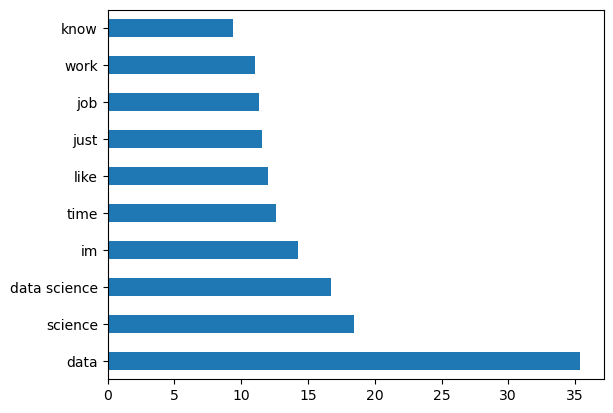

In [70]:
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [71]:
# Instantiate (w/ ngrams)
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 2), min_df=2)

#Fit
cvec.fit(X_train)

#Transform
X_train_cv = cvec.transform(X_train)
X_test_cv = cvec.transform(X_test)

In [72]:
X_train_cv.shape

(1191, 7883)

In [73]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening

X_train_df = pd.DataFrame(X_train_cv.todense(), columns=cvec.get_feature_names())

c:\Users\muham\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



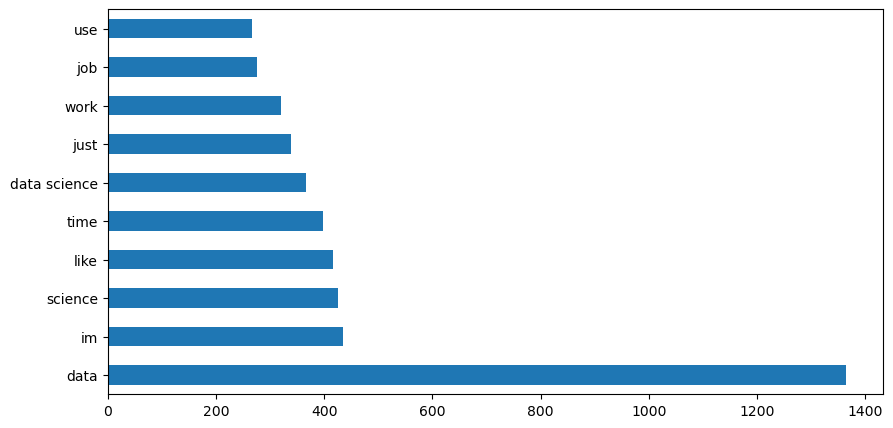

In [74]:
# Plot top occuring words

plt.figure(figsize=(10, 5))
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [75]:

pipe_tvec = Pipeline([('tvec', TfidfVectorizer()),('logit', LogisticRegression())])

In [76]:

# pgrid = {
#     'tvec__stop_words': [None, 'english'],
#     'tvec__min_df': [1, 2, 3],
#     'tvec__ngram_range': [(1, 1), (1, 2), (2,2),(3,3)],
#     'logit__penalty': ['l1','l2'],
#     'logit__C': [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50],
#     'logit__max_iter': [1000],
#     'logit__solver': ['lbfgs','liblinear']


# }


In [77]:
pgrid = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1, 1)],
    'logit__penalty': ['l1','l2'],
    'logit__C': [0.0001,0.0005],
    'logit__max_iter': [1000],
    'logit__solver': ['liblinear']


}

In [78]:
X_train=tvec.fit_transform(X_train)

In [79]:
X_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [80]:
gs_tvec = GridSearchCV(LogisticRegression(), pgrid, cv=10, n_jobs=6)

In [81]:

gs_tvec.fit(X_train, y_train)

ValueError: Invalid parameter logit for estimator LogisticRegression(). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
lg = LogisticRegression(C=0.0001, penalty='l2', max_iter=1000)
lg.fit(X_train, y_train)


ValueError: could not convert string to float: ': TIL that energy stocks are actually war stocks! : I dont know if anyone else sees the account unusual\\_whales on twitter always trying to shill his shitty alerts service or trying to get credit for eXpOsInG CoRRupTiOn.Here they claim that "BREAKING: Congress has been buying war stocks!"[Lets look at the "war stocks" these people bought![All dividend reinvestments, probably part of a DRIP program, in an energy company.... What a shocking trade. Fucking moron ]([cybersecurity stock in... August? So FTNT, a ticker which btw did not pump on war news, was apparently a trade based on the recent war.]([XOM... The most recent purchase was months ago. Plus more dividend reinvestments. Plenty of regards are buying oil in this market, this doesnt mean shit. Im sure whoever is in charge of unusual whales saw that XOM pumped today and just searched it on their service. ]([General Dynamics, this would be pretty damning except that the most recent purchase was in June and they conveniently includes screenshots from over a year ago to make it look more substantial](&#;Im not saying corruption isnt there, but this account will manufacture a story and uses that to get subs to his service or claim his alerts service can see insider moves ahead of time. Also somehow manages to pass as legitimate news, people (usually AMC apes or stupider) take this stupid ass account seriously'

In [ ]:
%%time
gs_tvec.fit(X_train, y_train)

c:\Users\muham\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


240 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\muham\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\muham\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\muham\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1516, in fit
    check_classification_targets(y)
  File "c:\Use

ValueError: Unknown label type: 'unknown'

In [ ]:
cvec.score(X_train, y_train)

AttributeError: 'CountVectorizer' object has no attribute 'score'

# Peform similar EDA for Unigram, bigram and Trigrams

## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

#### Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

#### Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:

#### Other visualizations:

Create 1-2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Barcharts of users per category per trait
- A seaborn correlation heatmap
- A seaborn pairplot

_________________

import datetime
 
unixToDatetime = datetime.datetime.fromtimestamp(1661324766) # Unix Time
print(unixToDatetime)

In [ ]:
#Expanding Contractions (Source : Dipanjan-Sarkar-Text-Analytics-with-Python; Sarkar, Dipanjan)

from contractions import CONTRACTION_MAP
import re
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
 contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
 def expand_match(contraction):
    match = contraction.group(0)
    first_char = match[0]
    expanded_contraction = contraction_mapping.get(match)\
                            if contraction_mapping.get(match)\
                            else contraction_mapping.get(match.lower())
    expanded_contraction = first_char+expanded_contraction[1:]
    return expanded_contraction
 expanded_text = contractions_pattern.sub(expand_match, text)
 expanded_text = re.sub("'", "", expanded_text)
 return expanded_text


In [ ]:
#Correcting Repeating Characters
def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

In [ ]:
default_st = nltk.sent_tokenize
#alice_sentences = default_st(text=boardgames['self_text'])
boardgames['tokenized_sentences'] = boardgames['self_text'].apply(nltk.sent_tokenize)
all_sentences = [sentence for post_sentences in boardgames['tokenized_sentences'] for sentence in post_sentences]

#sample_sentences = default_st(text=sample_text)

In [ ]:
all_sentences

['I have a strong belief that the best data projects are the most personal ones.',
 'The ones that are clearly made by, well, you.',
 "To make them personal, this often means that you have to learn some skills that aren't exactly data science related.",
 "It's difficult to make something personal with just a Jupyter Notebook.",
 'Projects should look pretty, be easily accessible on the web, and free for both you and the user.',
 'We use PythonAnywhere to get this done for most of our portfolio projects.',
 'Some of the skills that will really help make a great project, that would compliment your data skills, are:\n\n\\- HTML\n\n\\- CSS\n\n\\- Web development (Flask, Django, Node)\n\n\\- Tableau - Cloud (GCP, AWS)\n\n\\- ...',
 'Anything that you find interesting\n\nThat last point is important.',
 'I often get asked how to come up with ideas.',
 'The best ideas come from whatever you are truly passionate about, and by not limiting yourself by trapping your skillset in an imaginary box.

In [ ]:
default_wt = nltk.word_tokenize
words = [nltk.word_tokenize(sentence) for sentence in all_sentences]
array_words = np.array([word for sentence in words for word in sentence])


In [ ]:
expanded_words = [expand_contractions(word) for word in array_words]


Parts of Speech Tagging:
sentence → clauses → phrases → words

## 2. You'll then use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

For Project 3 the evaluation categories are as follows:
The Data Science Process

Problem Statement

Data Collection

Data Cleaning & EDA :

-->Removing HTML tags
• Tokenization
• Removing unnecessary tokens and stopwords
• Handling contractions
• Correcting spelling errors
• Stemming
• Lemmatization
• Tagging
• Chunking
• Parsing

AKA

 Clean the text data: Remove special characters, URLs, and numbers, and convert to lowercase.
__Tokenize the text and remove stopwords.__
__Vectorize the text using techniques like TF-IDF (Term Frequency-Inverse Document Frequency) or word embeddings.__


Preprocessing & Modeling: Split the data into training and testing sets.
Train a binary classification model. Common choices for text data include Logistic Regression, Naive Bayes, or more complex models like LSTM (Long Short-Term Memory) or Transformer-based models.
Evaluate the model on the test set to understand its accuracy and other metrics.

Evaluation and Conceptual Understanding: Use metrics like accuracy, precision, recall, and the F1 score to evaluate the model's performance.
Adjust hyperparameters or try different models if needed.

Deployment (Optional):

If you're satisfied with the model's performance, you can deploy it as an API or integrate it into an application.

Conclusion and Recommendations:


Rubric
Your instructors will evaluate your project (for the most part) using the following criteria. You should make sure that you consider and/or follow most if not all of the considerations/recommendations outlined below while working through your project.

For Project 3 the evaluation categories are as follows:
The Data Science Process

Problem Statement
Data Collection
Data Cleaning & EDA
Preprocessing & Modeling
Evaluation and Conceptual Understanding
Conclusion and Recommendations
Organization and Professionalism

Organization
Visualizations
Python Syntax and Control Flow
Presentation
Scores will be out of 30 points based on the 10 categories in the rubric.
3 points per section

Score	Interpretation
0	Project fails to meet the minimum requirements for this item.
1	Project meets the minimum requirements for this item, but falls significantly short of portfolio-ready expectations.
2	Project exceeds the minimum requirements for this item, but falls short of portfolio-ready expectations.
3	Project meets or exceeds portfolio-ready expectations; demonstrates a thorough understanding of every outlined consideration.
The Data Science Process
Problem Statement

Is it clear what the goal of the project is?
What type of model will be developed?
How will success be evaluated?
Is the scope of the project appropriate?
Is it clear who cares about this or why this is important to investigate?
Does the student consider the audience and the primary and secondary stakeholders?
Data Collection

Was enough data gathered to generate a significant result? (At least 1000 posts per subreddit)
Was data collected that was useful and relevant to the project?
Was data collection and storage optimized through custom functions, pipelines, and/or automation?
Was thought given to the server receiving the requests such as considering number of requests per second?
Data Cleaning and EDA

Are missing values imputed/handled appropriately?
Are distributions examined and described?
Are outliers identified and addressed?
Are appropriate summary statistics provided?
Are steps taken during data cleaning and EDA framed appropriately?
Does the student address whether or not they are likely to be able to answer their problem statement with the provided data given what they've discovered during EDA?
Preprocessing and Modeling

Is text data successfully converted to a matrix representation?
Are methods such as stop words, stemming, and lemmatization explored?
Does the student properly split and/or sample the data for validation/training purposes?
Does the student test and evaluate a variety of models to identify a production algorithm (AT MINIMUM: two models)?
Does the student defend their choice of production model relevant to the data at hand and the problem?
Does the student explain how the model works and evaluate its performance successes/downfalls?
Evaluation and Conceptual Understanding

Does the student accurately identify and explain the baseline score?
Does the student select and use metrics relevant to the problem objective?
Does the student interpret the results of their model for purposes of inference?
Is domain knowledge demonstrated when interpreting results?
Does the student provide appropriate interpretation with regards to descriptive and inferential statistics?
Conclusion and Recommendations

Does the student provide appropriate context to connect individual steps back to the overall project?
Is it clear how the final recommendations were reached?
Are the conclusions/recommendations clearly stated?
Does the conclusion answer the original problem statement?
Does the student address how findings of this research can be applied for the benefit of stakeholders?
Are future steps to move the project forward identified?
Organization and Professionalism
Project Organization

Are modules imported correctly (using appropriate aliases)?
Are data imported/saved using relative paths?
Does the README provide a good executive summary of the project?
Is markdown formatting used appropriately to structure notebooks?
Are there an appropriate amount of comments to support the code?
Are files & directories organized correctly?
Are there unnecessary files included?
Do files and directories have well-structured, appropriate, consistent names?
Visualizations

Are sufficient visualizations provided?
Do plots accurately demonstrate valid relationships?
Are plots labeled properly?
Are plots interpreted appropriately?
Are plots formatted and scaled appropriately for inclusion in a notebook-based technical report?
Python Syntax and Control Flow

Is care taken to write human readable code?
Is the code syntactically correct (no runtime errors)?
Does the code generate desired results (logically correct)?
Does the code follows general best practices and style guidelines?
Are Pandas functions used appropriately?
Are sklearn and NLTK methods used appropriately?
Presentation

Is the problem statement clearly presented?
Does a strong narrative run through the presentation building toward a final conclusion?
Are the conclusions/recommendations clearly stated?
Is the level of technicality appropriate for the intended audience?
Is the student substantially over or under time?
Does the student appropriately pace their presentation?
Does the student deliver their message with clarity and volume?
Are appropriate visualizations generated for the intended audience?
Are visualizations necessary and useful for supporting conclusions/explaining findings?
Why did we choose this project for you?
This project covers three of the biggest concepts we cover in the class: Classification Modeling, Natural Language Processing and Data Wrangling/Acquisition.



-=================================



Part 1 of the project focuses on Data wrangling/gathering/acquisition. This is a very important skill as not all the data you will need will be in clean CSVs or a single table in SQL. There is a good chance that wherever you land you will have to gather some data from some unstructured/semi-structured sources; when possible, requesting information from an API, but sometimes scraping it because they don't have an API (or it's terribly documented).

Part 2 of the project focuses on Natural Language Processing and converting standard text data (like Titles and Comments) into a format that allows us to analyze it and use it in modeling.

Part 3 of the project focuses on Classification Modeling. Given that project 2 was a regression focused problem, we needed to give you a classification focused problem to practice the various models, means of assessment and preprocessing associated with classification.